In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from numpy.linalg import multi_dot, inv
%matplotlib inline
import loss

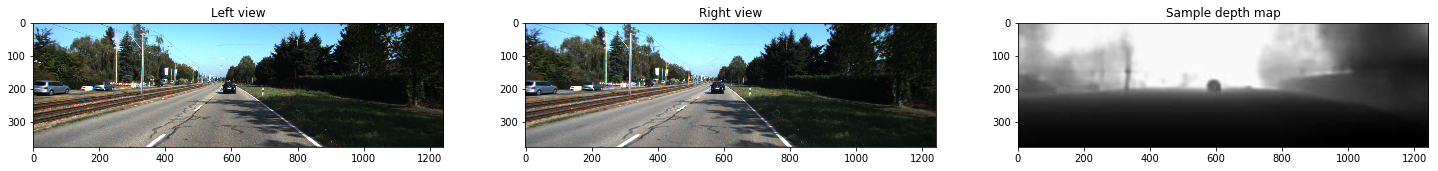

In [2]:
image_idx = 11
image_dir = '/data/KITTI/KITTI_RAW/2011_09_26/2011_09_26_drive_0015_sync/'
left_view = mpimg.imread(image_dir + 'image_02/data/' + "{:010}".format(image_idx) + '.png')
right_view = mpimg.imread(image_dir + 'image_03/data/' + "{:010}".format(image_idx) + '.png')

ref = mpimg.imread('/home/szuyu/workspace/semodepth/encode/2011_09_26_drive_0015/0000000011.jpg', 0)
ref = ref / 3 #reverse previous enhancement
ref = cv2.resize(ref, (left_view.shape[1], left_view.shape[0]))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,6))
ax1.set_title('Left view')
ax1.imshow(left_view)
ax2.set_title('Right view')
ax2.imshow(right_view)
ax3.imshow(ref, cmap='gray')
ax3.set_title("Sample depth map")
plt.show()

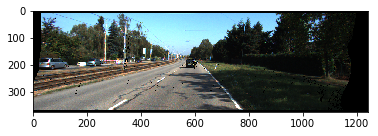

In [3]:
A = loss.reconstruct(ref, np.array(left_view), 'L2R')
plt.imshow(A)
plt.show()

In [4]:
loss.recon_loss(right_view, A)

5164.0288

In [5]:
velo_path = image_dir + 'velodyne_points/data/'
image_path = image_dir + 'image_02/data'

v2c_filepath = '/data/KITTI/KITTI_RAW/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '/data/KITTI/KITTI_RAW/2011_09_26/calib_cam_to_cam.txt'

dots=loss.crop_lidar(image_path,velo_path,v2c_filepath,c2c_filepath, frame_id=image_idx)
loss.gt_loss(ref, dots)

476.9994

In [8]:
"""def show_lidar(img, dots):
    canvas = (img*255).astype(np.uint8)
    canvas = cv2.cvtColor(canvas, cv2.COLOR_RGB2HSV)
    for i in range(dots.shape[0]):
        for j in range(dots.shape[1]):
            if dots[i][j]:
                cv2.circle(canvas, (j,i), 2, (int(dots[i][j]),255,255),-1)

    canvas = cv2.cvtColor(canvas, cv2.COLOR_HSV2RGB)
    plt.subplots(1,1, figsize = (18,5)) #13,3
    plt.title('Lidar data')
    plt.imshow(canvas)
    
show_lidar(left_view, dots)"""



"def show_lidar(img, dots):\n    canvas = (img*255).astype(np.uint8)\n    canvas = cv2.cvtColor(canvas, cv2.COLOR_RGB2HSV)\n    for i in range(dots.shape[0]):\n        for j in range(dots.shape[1]):\n            if dots[i][j]:\n                cv2.circle(canvas, (j,i), 2, (int(dots[i][j]),255,255),-1)\n\n    canvas = cv2.cvtColor(canvas, cv2.COLOR_HSV2RGB)\n    plt.subplots(1,1, figsize = (18,5)) #13,3\n    plt.title('Lidar data')\n    plt.imshow(canvas)\n    \nshow_lidar(left_view, dots)"